# IN4080 - Assignment 3  
Markus Sverdvik Heiervang - markuhei  

***  

## Part 1: chatbot  



In [1]:
import os, random, gzip, json, re
import tensorflow as tf
import tensorflow.keras as keras
import encoder_client
import numpy as np
import itertools
import functools
import operator

# For serialization
import pickle

I did so many changes to the class that i thought it was just better to copy the entire class over to this notebook than to swap all the methods. I added optional serialization to save time, meaning that i only had to compute the embeddings once.  

Another thing I had to add was random state/seed. When doing machine learning experiments, assuring reproducibility is really important. We do this by applying seeds to the random number generators of numpy and tensorflow. Keras' dense layers are by default initialized with random samples from the uniform distribution as weights.

In [2]:
DIALOGUE_FILE = "data/en-comedy.txt.gz"
FIRST_NAMES = "data/first_names.json"
MODEL_URI = "https://nr.no/~plison/data/model.tar.gz"

class Chatbot:
    """A dual encoder model for a Retrieval chatbot"""

    def __init__(self, dialogue_data=DIALOGUE_FILE, embedding_path=None, random_state=None):
        """Initialises a chatbot based on a Dual Encoder architecture, with
        utterances encoded using the pre-trained ConveRT model
        (https://arxiv.org/abs/1911.03688)."""

        if random_state is not None:
            np.random.seed(random_state)
            tf.random.set_seed(random_state)

        # Loads the ConveRT utterance encoder
        self.client = encoder_client.EncoderClient(MODEL_URI)
        if embedding_path and os.path.exists(embedding_path):
            with open(embedding_path, "rb") as f:
                self.pairs, self.responses, self.response_embeddings = pickle.load(f)
        else:
            # Extracts the (context, response) pairs
            self.pairs = self._extract_pairs(dialogue_data)

            # Compute the embeddings for the responses (takes some time to compute!)
            self.responses = [response for _, response in self.pairs]
            self.response_embeddings = self.client.encode_responses(self.responses)

            if embedding_path:
                with open(embedding_path, "wb+") as f:
                    pickle.dump([self.pairs, self.responses, self.response_embeddings], f)


    def _extract_pairs(self, dialogue_data, max_nb_pairs=100000):
        """Given a file containing dialogue data, extracts a list of relevant
        (context,response) pairs, where both the context and response are
        strings. The 'context' is here simply the first utterance (such as a question),
        and the 'response' the following utterance (such as an answer).

        The (context, response) pairs should satisfy the following critera:
        - The two strings should be consecutive, and part of the same movie/TV series
        - Pairs in which one string contains parentheses, brackets, colons, semi-colons
          or double quotes should be discarded.
        - Pairs in which one string is entirely in uppercase should be discarded
        - Pairs in which one string contains more than 10 words should be discarded
        - Pairs in which one string contains a first name should be discarded
          (see the json file FIRST_NAMES to detect those).

        You are of course free to add additional critera to increase the quality of your
        (context,response) pairs. You should stop the extract once you have reached
        max_nb_pairs.

        """
        a = list(self._pair_gen(dialogue_data, max_nb_pairs))
        return a


    def _pair_gen(self, dialogue_data, max_nb_pairs, separator=b"###"):
        """Auxiliary generator function for _extract_pairs
        """

        nb_pairs = 0
        with gzip.open(dialogue_data) as reader:
            if next(reader, None) is None: return
            with open("data/first_names.json") as name_file:
                names = [bytes(i, encoding="UTF8") for i in json.load(name_file)]
            iterator, empty = next(reader, None), None
            while iterator is not empty:
                prev = iterator
                for line in itertools.takewhile(lambda x: not x.startswith(separator), reader):
                    valid_punctuation = all(c not in line for c in b"()[]:;\"")
                    valid_case = not line.isupper()
                    valid_length = len(line.split()) <= 10
                    valid_name = all(name not in line for name in names)

                    if valid_punctuation and valid_case and valid_length and valid_name:
                        if prev is not None:
                            yield prev, line
                            nb_pairs += 1
                            if nb_pairs >= max_nb_pairs: return
                        prev = line
                    else:
                        prev = None

                iterator = next(reader, None)


    def get_response(self, user_utterance):
        """Extracts the context embedding for the user utterance, and then computes
        the dot product of this embeddings with all the response embeddings (already
        computed in self.response_embeddings). The response with the highest dot
        product is then selected.

        To get the context embedding for the user utterance, simply use the method
        client.encode_contexts(...).

        The method returns a string with the response of the chatbot."""
        context_embedding = self.client.encode_contexts([user_utterance])
        argmax = np.argmax(self.response_embeddings @ context_embedding.T)
        return self.responses[argmax].decode("UTF8")


    def fine_tune(self, epochs=10):
        """Fine-tunes the dual encoder model by computing a transformation (linear
        transformation + non-linear ReLU activation) of the response embeddings,
        optimised on the (context, response) pairs extracted for the dataset.
        The method updates the response embeddings with the transformed values"""

        # Extract the training data (with both positive and negative examples)
        context_embeddings2, response_embeddings2, outputs = self._get_training_data()

        # Creates the two input layers (for the two embeddings)
        input1 = tf.keras.layers.Input((context_embeddings2.shape[1],))
        input2 = tf.keras.layers.Input((response_embeddings2.shape[1],))

        # Computes the transformation of the response embeddings
        dense2 = tf.keras.layers.Dense(response_embeddings2.shape[1], activation="relu")

        # Computes the dot product, and pass through a sigmoid to get a probability
        dotproduct = tf.keras.layers.Dot(axes=1)
        sigmoid = tf.keras.layers.Activation(tf.keras.activations.sigmoid)

        # Connects together all layers
        output_prob = sigmoid(dotproduct([input1, dense2(input2)]))

        # Creates a new model, specifying the inputs and output
        model = tf.keras.Model([input1, input2], output_prob)
        model.summary()

        # Compile the model the "Adam" optimiser and a cross-entropy loss
        model.compile(loss="binary_crossentropy", optimizer="adam")

        # Train the model on 10 epochs
        model.fit([context_embeddings2, response_embeddings2], outputs,
                  batch_size=32,epochs=epochs)

        # Once the model is trained, we simple transform the response embeddings using
        # the transformation we have learned
        embeddings_tensor = dense2(self.response_embeddings)
        self.response_embeddings = tf.keras.backend.eval(embeddings_tensor)


    def _get_training_data(self, context_embedding_path=None):
        """Constructs a dataset to fine-tune the dual encoder. The dataset should
        contain both positive examples (that is, pairs of context and response embeddings
        that do correspond to actual response pairs) and negative examples (pairs of context
        and response embeddings that are selected at random and are not related).

        More precisely, the method should return 3 outputs:
        - one matrix of shape (2*len(self.pairs), 512) with context embeddings from the pairs
        - one matrix of shape (2*len(self.pairs), 512) with response embeddings from the pairs
        - one array of shape 2*len(self.pairs) with binary values

        Half of the training examples should be positive (actual pair of embeddings) and half
        should be negative (pair of embeddings selected at random), which is why the total length
        of the training data is twice the number of (context, response) pairs. For positive examples,
        the corresponding value in the output array should be 1, and 0 for negative examples.

        The response embeddings have already been computed (in self.response_embeddings) so you
        don't need to compute them again. But you need to compute the context embeddings for your
        pairs using the method client.encode_contexts(contexts).

        Note that the positive and negative examples should be shuffled (to avoid confusing the
        machine learning model by first starting with only positive examples, then having only
        negative examples).
        """
        # N will be the size of ur pairs
        k = len(self.pairs)
        N = 2*k

        if not hasattr(self, "context_embeddings"):
            if context_embedding_path and os.path.exists(context_embedding_path):
                with open(context_embedding_path, "rb") as f:
                    self.contexts, self.context_embeddings = pickle.load(f)
            else:
                self.contexts = [c for c, _ in self.pairs]
                self.context_embeddings = self.client.encode_responses(self.contexts)
                if context_embedding_path:
                    with open(context_embedding_path, "wb+") as f:
                        pickle.dump((self.contexts, self.context_embeddings), f)
                        print("Sucessfully wrote to", context_embedding_path)

        negative_responses = self.response_embeddings.copy()
        np.random.shuffle(negative_responses)

        context = np.concatenate((self.context_embeddings, self.context_embeddings))
        response = np.concatenate((self.response_embeddings, negative_responses))
        target = np.concatenate((np.ones(k), np.zeros(k)))

        perm = np.random.permutation(N)

        return context[perm], response[perm], target[perm]

In [3]:

ep = "serial_data.pkl"

cb = Chatbot(embedding_path=ep, random_state=42)

I1113 22:37:54.911129 3766 resolver.py:79] Using /tmp/tfhub_modules to cache modules.
I1113 22:37:54.916354 3766 resolver.py:416] Downloading TF-Hub Module 'https://nr.no/~plison/data/model.tar.gz'.
I1113 22:38:07.935929 3766 resolver.py:122] Downloaded https://nr.no/~plison/data/model.tar.gz, Total size: 152.02MB
I1113 22:38:07.937726 3766 resolver.py:431] Downloaded TF-Hub Module 'https://nr.no/~plison/data/model.tar.gz'.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:10.786688 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:12.092604 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:13.416030 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


In [4]:
def get_sample_responses(chatbot):
    sample_context = [
        "Who are you?",
        "Where are you?",
        "How old are you?",
        "What is better than chicken soup?",
        "What is the name of USA's president?",
        "What is the species of Mark Zuckerberg?"
    ]
    
    for c in sample_context:
        r = chatbot.get_response(c)
        print("\nContext:", c)
        print("Response:", r)

In [5]:
get_sample_responses(cb)

I1113 22:38:29.215152 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.557791 3766 encoder_client.py:213] Encoded 1 examples in 2.343 seconds
I1113 22:38:31.603714 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.656604 3766 encoder_client.py:213] Encoded 1 examples in 0.053 seconds
I1113 22:38:31.687384 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.726227 3766 encoder_client.py:213] Encoded 1 examples in 0.039 seconds
I1113 22:38:31.763630 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.800792 3766 encoder_client.py:213] Encoded 1 examples in 0.037 seconds



Context: Who are you?
Response: I'll tell you who I am.


Context: Where are you?
Response: I'm at the spa.


Context: How old are you?
Response: I'm 15.



I1113 22:38:31.832256 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.866463 3766 encoder_client.py:213] Encoded 1 examples in 0.034 seconds
I1113 22:38:31.894149 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:38:31.928511 3766 encoder_client.py:213] Encoded 1 examples in 0.034 seconds



Context: What is better than chicken soup?
Response: Fish soup.


Context: What is the name of USA's president?
Response: The bank president.


Context: What is the species of Mark Zuckerberg?
Response: Reptile.



Some interesing results;

In [6]:
ft = Chatbot(embedding_path="serial_data.pkl", random_state=42)
ft._get_training_data(context_embedding_path="context_embeddings.pkl")
ft.fine_tune()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:35.392872 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:36.660498 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:38:38.116065 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore
I1113 22:38:40.035598 3766 encoder_client.py:196] Encoding 78436 examples.
I1113 22:39:00.072528 3766 encoder_client.py:201] Encoded 4544 / 78436  (5.8%)
I1113 22:39:20.334538 3766 encoder_client.py:201] Encoded 9728 / 78436  (12.4%)
I1113 22:39:40.652751 3766 encoder_client.py:201] Encoded 14016 / 78436  (17.9%)
I1113 22:40:00.948886 3766 encoder_client.py:201] Encoded 18368 / 78436  (23.4%)
I1113 22:40:21.112281 3766 encoder_client.py:201] Encoded 22400 / 78436  (28.6%)
I1113 22:40:41.331428 3766 encoder_client.py:201] Encoded 26048 / 78436  (33.2%)
I1113 22:41:01.560943 3766 encoder_client.py:201] Encoded 29760 / 78436  (37.9%)
I1113 22:41:21.966398 3766 encoder_client.py:201] Encoded 33280 / 78436  (42.4%)
I1113 22:41:41.991283 3766 encoder_client.py:201] Encoded 36480 / 78436  (46.5%)
I1113 22:42:01.994060 3766 encoder_client.py:201] Encoded 39552 / 78436  (50.4%)
I11

Sucessfully wrote to context_embeddings.pkl
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          262656      input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1)            0           input_1[0][0]                    
                                           

In [7]:
get_sample_responses(ft)

I1113 22:51:31.233206 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:51:32.199136 3766 encoder_client.py:213] Encoded 1 examples in 0.966 seconds
I1113 22:51:32.220657 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:51:32.248235 3766 encoder_client.py:213] Encoded 1 examples in 0.028 seconds
I1113 22:51:32.277886 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:51:32.298898 3766 encoder_client.py:213] Encoded 1 examples in 0.021 seconds
I1113 22:51:32.338680 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:51:32.377384 3766 encoder_client.py:213] Encoded 1 examples in 0.039 seconds
I1113 22:51:32.405515 3766 encoder_client.py:196] Encoding 1 examples.



Context: Who are you?
Response: I don't know who I am.


Context: Where are you?
Response: - Where is she?


Context: How old are you?
Response: -I don't want to talk to her right now.


Context: What is better than chicken soup?
Response: I'm making breakfast.



I1113 22:51:32.442628 3766 encoder_client.py:213] Encoded 1 examples in 0.037 seconds
I1113 22:51:32.480080 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:51:32.516567 3766 encoder_client.py:213] Encoded 1 examples in 0.036 seconds



Context: What is the name of USA's president?
Response: I'm afraid he isn't here at the moment, miss.


Context: What is the species of Mark Zuckerberg?
Response: He's my ex-husband.



Our results get slightly worse than before fine tuning. By looking at our results, it is apparent that the loss has not really converged, and is still a little too high. We can probably get a lower loss score without overfitting, by increasing the epochs 

In [8]:
ft2 = Chatbot(embedding_path="serial_data.pkl", random_state=42)
ft2._get_training_data(context_embedding_path="context_embeddings.pkl")
ft2.fine_tune(epochs=20)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:51:35.908485 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:51:38.097243 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I1113 22:51:39.674233 3766 saver.py:1512] Saver not created because there are no variables in the graph to restore


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      input_4[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1)            0           input_3[0][0]                    
                                                                 dense_1[0][0]         

In [9]:
ft2.get_response("What is better than chicken soup?")

I1113 22:59:13.260916 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.313084 3766 encoder_client.py:213] Encoded 1 examples in 1.052 seconds


"I'm making breakfast.\n"

In [10]:
get_sample_responses(ft2)

I1113 22:59:14.373043 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.398319 3766 encoder_client.py:213] Encoded 1 examples in 0.025 seconds
I1113 22:59:14.423150 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.448733 3766 encoder_client.py:213] Encoded 1 examples in 0.026 seconds
I1113 22:59:14.473195 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.507256 3766 encoder_client.py:213] Encoded 1 examples in 0.034 seconds
I1113 22:59:14.552717 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.590106 3766 encoder_client.py:213] Encoded 1 examples in 0.037 seconds



Context: Who are you?
Response: I don't know who I am.


Context: Where are you?
Response: - Where is she?


Context: How old are you?
Response: - She's gone.


Context: What is better than chicken soup?
Response: I'm making breakfast.


Context: What is the name of USA's president?
Response: I don't know where she is.



I1113 22:59:14.620870 3766 encoder_client.py:196] Encoding 1 examples.
I1113 22:59:14.664051 3766 encoder_client.py:213] Encoded 1 examples in 0.043 seconds



Context: What is the species of Mark Zuckerberg?
Response: He's my ex-husband.



Though worth an attempt, the increase of epochs did not really seem to give better results. Doubling number of epochs gave a slightly lower loss, but no noticably improved results. 
If i were to investigate further, I would try fitting the finetuning layer even further, and perhaps with more parameters as well. It might also be the case that our dataset is a little noisy, where the examples of bad responses actually were good or vice versa. Perhaps it could be measured by using dot products between the sentences in the original encoder.

## Part 2: audio processing

In [11]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
fs, data = scipy.io.wavfile.read("data/excerpt.wav")
data = data.astype(np.int32)

The fs constant describes the frequency of the audio file. As displayed below, this audio file has a frequency of 16kHz

In [48]:
fs

16000

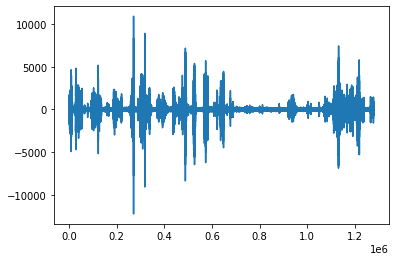

In [12]:
plt.plot(data)

We plot the first second of the data

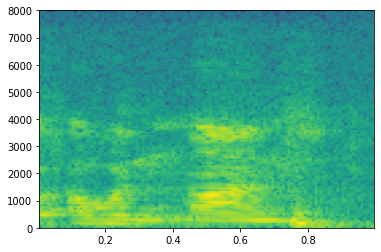

In [25]:
plt.specgram(data[:fs], Fs=fs)
None

The total energy of our audio is:

In [26]:
energy = np.sum(data**2)
energy

200416094535

assuming our clip is 16khz, 100 ms would equate to 160 values

In [27]:
window_starts = np.arange(0, len(data)-320, 160)
window_ends = np.arange(320, len(data), 160)


In [28]:
windows = np.vstack((window_starts, window_ends)).T

this could probably be vectorized, but i didnt find a clever way in time

In [29]:
energies = np.array([np.sum(data[s:e]**2) for s, e in windows])
energies

array([157697425, 174021648,  98926905, ...,  93406128,  91924764,
        66350261])

In [30]:
mean_e = energies.mean()
mean_e

50167938.291061595

In [31]:
frames_silent = energies <= mean_e / 10

The red lines in the plot describes our detected silence

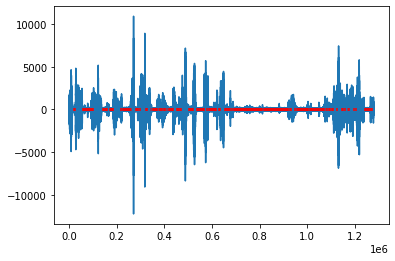

In [32]:
plt.plot(data, zorder=0)
for i, (s, e) in enumerate(windows):
    current = data[s:e]
    if frames_silent[i]:
        plt.hlines(0, xmin=s, xmax=e, lw=3, color="r", zorder=1)

In [33]:
from functools import reduce
window_size = len(energies)
shifter = np.pad(energies, 5)
left = [shifter[5-i:-i-5] for i in range(5, 0, -1)]
mid = [shifter[5:-5]]
right = [shifter[5+i:i-5] for i in range(1, 6)]


In [34]:
def get_5_nbs(arr):
    shifter = np.pad(arr, 5)
    left = [shifter[5-i:-i-5] for i in range(5, 0, -1)]
    mid = [shifter[5:-5]]
    right = [shifter[5+i:len(shifter)-(5-i)] for i in range(1, 6)]
    return left + mid + right

pred = lambda x: x <= mean_e/10

frames_silent_better = reduce(operator.and_, map(pred, get_5_nbs(energies)))
frames_silent_better.sum(), frames_silent.sum()

(3923, 4880)

This time, the silence is a little more sparsely distributed

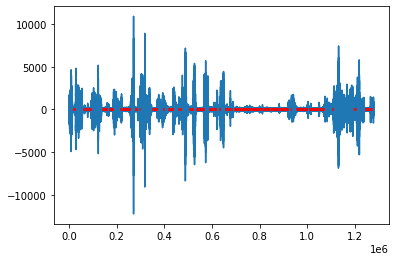

In [35]:
plt.plot(data, zorder=0)
for i, (s, e) in enumerate(windows):
    current = data[s:e]
    if frames_silent_better[i]:
#         thickness = np.mean(current)/2
        thickness = 3
        plt.hlines(0, xmin=s, xmax=e, lw=thickness, color="r", zorder=1)

## Part 3: Talking elevator

The system should be able to properly respond to the requirements mentioned in the task description.  
In my implementation, all the employees happened to be at the same floor

In [51]:
import random
import re
from elevator import TalkingElevator

random.seed(42)
def process(self, user_message, confidence_score):
    """Process the user inputs"""
    if not hasattr(self, "state"):
        self.state = "init"
    
    if not hasattr(self, "threshold"):
        self.threshold = 0.7
        
    user_message = user_message.lower()    
    if self.state == "init":
        self.respond("Welcome to this voice activated elevator: The Intelevator. What is your destination floor?")
        self.state = "select_floor"
        
    elif confidence_score <= self.threshold:
        repeat_responses = [
            "Sorry, I did not quite catch that. Could you repeat yourself?",
            "I did not understand that. Care to repeat yourself?", 
            "Could you stop mumbling and speak a little more clearly? Can't understand you at all"
        ]
        
        self.respond(random.choice(repeat_responses))
        
    elif re.match(r"goodbye|bye", user_message):
        self.respond("See you some other time.")
        self.state = "init"
    elif re.match(r"(stop|no)", user_message):
        self.urgent_stop = True
        self.respond("Stopping elevator. Where would you like go?")
        self.state = "select_floor"
    elif self.state == "select_floor":
        result = re.findall(r"((^|\s)([0-9]|10)(\s|$))", user_message)
        if result:
            if len(result) == 1:
                if type(result[0]) == tuple:
                    floor = int(result[0][0])
                else: 
                    floor = int(result[0])
                if floor in range(11):
                    self.respond(f"Taking you to floor {floor}")
                    self.go_to(floor)
                else:
                    self.respond("There is no such floor. Please select a different floor")
            else:
                self.respond("would you like to go to foor " + " or ".join(result) + "?")
        elif re.findall("r(erik\svelldal|lilja\søverlid|pierre\slison|jan\store\slønning|jeremy\sbarnes)", user_message):
            self.respond("On the 4th floor. Do you wish to go there?")
            self.state = "yesno"
        elif re.match(r"up", user_message):
            if self.cur_floor < 10:
                self.respond("Going up")
                self.go_to(self.cur_floor+1)
            else:
                self.respond("We're already at the top floor")
        elif re.match(r"down", user_message):
            if self.cur_floor > 1:
                self.respond("Going down")
                self.go_to(self.cur_floor-1)
            else:
                self.respond("We're already at the bottom floor")
        elif re.match(r"which.*floor", user_message):
            self.respond(f"We're on {self.cur_floor}")
        else:
            self.respond("Please state the floor number which you'd like to go to")
            
    elif self.state == "yesno":
        if "yes" in user_message:
            self.respond("Going to floor 4")
            self.state = "select_floor"
        elif "no" in user_message:
            self.respond("Ok. Where would you like to go")
            self.state = "select_floor"
        else:
            self.respond("Yes or no?")
    else:
        self.respond("Which floor would you like to go to?")
        self.state = "select_floor"

setattr(TalkingElevator, "process", process)

In [53]:
elevator = TalkingElevator()